读取数据

In [225]:
import pickle
import sys
D=1600
W=200
ID=4
def read_data(D,W):
    '''
    通过D,和W的大小来区分和读取数据，并返回四个数据结果。
    '''
    name=sys.path[0]+'\data\\'+'D='+str(D)+'_W='+str(W)
    
    with open(name+'_mouse_check.bin','rb') as file:
        check_datas=pickle.load(file)
    with open(name+'_mouse_move.bin','rb') as file:
        move_datas=pickle.load(file)
    with open(name+'_track.bin','rb') as file:
        track_datas=pickle.load(file)
    with open(name+'_information.bin','rb') as file:
        inf=pickle.load(file)
    
    return move_datas,check_datas,track_datas,inf

mouse_move,mouse_check,track,inf=read_data(D,W)

将轨迹数据转换为pd.DataFrame格式

In [226]:
import pandas as pd

Track={}
for i in range(len(track)):
    Track[i]=pd.DataFrame(track[i])
    Track[i].columns=['t','x','y']


计算轨迹数据中的其他相关项

In [227]:
import numpy as np

def setValue(Track):
    '''
    计算速度和时间
    '''
    trace=[]
    for i in range(len(Track)):
        T=Track[i].t.values
        X=Track[i].x.values
        Y=Track[i].y.values
        
        #将时间标准化
        t0=T[0]
        for i in range(len(T)):
            T[i]=T[i]-t0
            
        s=0
        S=[0,]#点在轨迹上的位置
        for i in range(1,len(X)):
            s+=np.sqrt((X[i]-X[i-1])**2+(Y[i]-Y[i-1])**2)
            S.append(s)
        
        v=[0,]
        alpha=[0,]
        for i in range(1,len(X)):
            
            v.append(np.sqrt((X[i]-X[i-1])**2+(Y[i]-Y[i-1])**2)/(T[i]-T[i-1]+1))
            #if X[i]!=X[i-1]:
                #print(X[i],X[i-1])
                #print(np.sqrt((X[i]-X[i-1])**2+(Y[i]-Y[i-1])**2)/(T[i]-T[i-1]+1))
            alpha.append(np.arctan((Y[i]-Y[i-1])/(X[i]-X[i-1]+1)))
        
        
        pandasDataSet=[]
        for i in range(len(X)):
            pandasDataSet.append((T[i],X[i],Y[i],S[i],v[i],alpha[i]))
        
        trace.append(pd.DataFrame(pandasDataSet,columns=['t','x','y','s','v','alpha']))
        
    return trace

Track=setValue(Track)



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


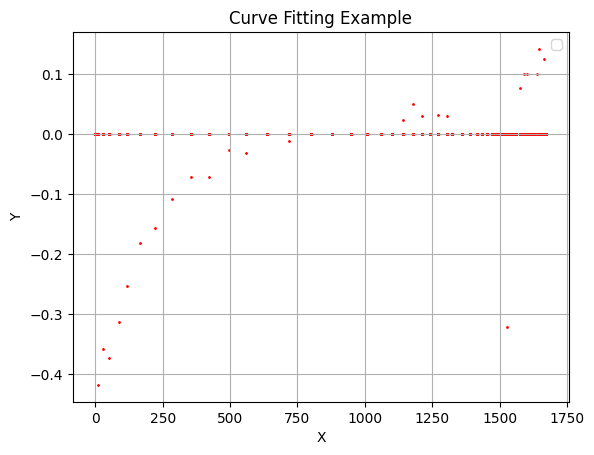

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


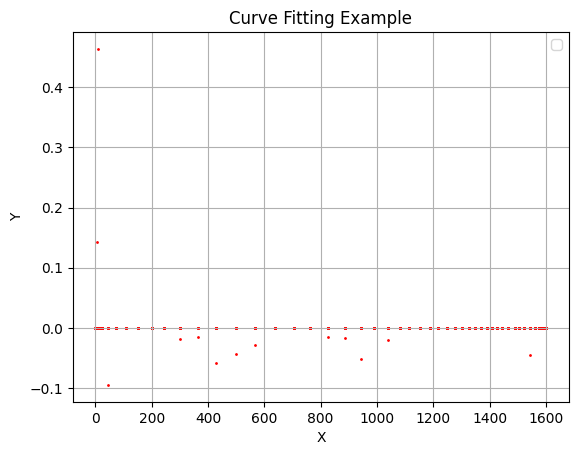

In [228]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

colors=['red','blue','green','yellow','pink','purple','orange','gray','brown',
        'red','blue','green','yellow','pink','purple','orange','gray','brown',]

for i in range(len(Track)):
    Y=np.array(Track[i].alpha.values.tolist())
    X=np.array(Track[i].s.values.tolist())
    #print(Y)
    #x_interp=np.linspace(0, max(X), 10000)
    
    #Y = linear_interpolation(X, Y, x_interp)
    #X=x_interp
    # 绘制原始数据和拟合曲线
    plt.scatter(X, Y, color='red',s=1)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Curve Fitting Example')
    plt.legend()
    plt.grid(True)
    plt.show()

进行拟合并计算拐点

C:\Users\smaug\AppData\Roaming\Python\Python39\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


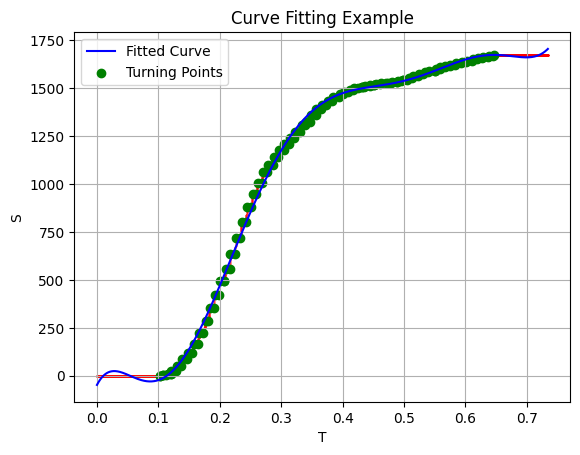

C:\Users\smaug\AppData\Roaming\Python\Python39\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


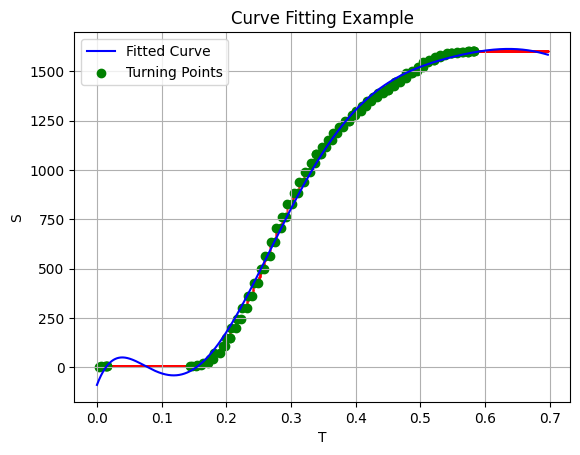

In [229]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

colors=['red','blue','green','yellow','pink','purple','orange','gray','brown',
        'red','blue','green','yellow','pink','purple','orange','gray','brown',]

def polynomial_func(x, *coefficients):
    n = int(len(coefficients)/2)
    result = np.zeros_like(x)
    for i in range(n):
        result += coefficients[i] * np.power(x,i)+coefficients[i+n]
    return result

def linear_interpolation(x_known, y_known, x_interp):
    """
    线性插值函数
    
    参数：
    x_known: 已知数据点的 x 坐标，数组或列表
    y_known: 已知数据点的 y 坐标，数组或列表
    x_interp: 需要进行插值的 x 坐标，单个值、数组或列表
    
    返回值：
    y_interp: 插值结果，与 x_interp 对应的 y 值，与 x_interp 的形状相同
    """
    f = interp1d(x_known, y_known, kind='linear')
    y_interp = f(x_interp)
    return y_interp

for i in range(len(Track)):
    #print(track[i])
    '''S=[]
    T=[]'''
    Y=np.array(Track[i].s.values.tolist())
    X=np.array(Track[i].t.values.tolist())
    '''for i in range(len(s)):
        S.append(s[i])
        T.append(t[i])'''
    
    x_interp=np.linspace(0, max(X), 10000)
    
    y_interp = linear_interpolation(X, Y, x_interp)
    
    
    # 使用 zip() 函数将两个列表配对并排序
    sorted_pairs = sorted(zip(x_interp, y_interp))

    # 解压排序后的配对，重新组合成两个列表
    X,Y = zip(*sorted_pairs)

    # 计算曲率
    dS = np.gradient(Y)
    dT = np.gradient(X)
    d2S = np.gradient(dS)
    d2T = np.gradient(dT)
    curvature = np.abs(dS * d2T - dT * d2S) / np.power(dS**2 + dT**2, 1.5)

    # 设置曲率阈值，判断转折点
    threshold = 0.9
    turning_points = np.array(np.where(curvature > threshold)[0])
    
    # 使用最小二乘法进行拟合
    initial_guess = np.zeros(8+8)  # 初始猜测参数
    popt, pcov = curve_fit(polynomial_func, np.array(X), np.array(Y), p0=initial_guess)

    # 绘制原始数据和拟合曲线
    
    plt.scatter(X, Y, color=colors[0],s=0.1)
    plt.plot(X, polynomial_func(X, *popt), color=colors[1], label='Fitted Curve')
    plt.scatter(np.array(X)[turning_points], np.array(Y)[turning_points], color='green', label='Turning Points')
    plt.xlabel('T')
    plt.ylabel('S')
    plt.title('Curve Fitting Example')
    plt.legend()
    plt.grid(True)
    plt.show()

XY的拐点

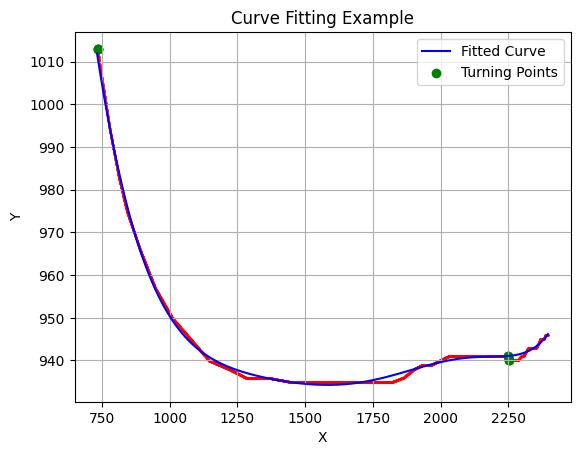

C:\Users\smaug\AppData\Roaming\Python\Python39\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


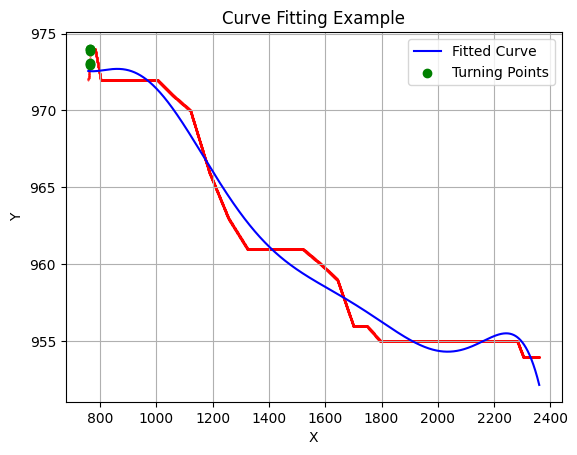

In [230]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

colors=['red','blue','green','yellow','pink','purple','orange','gray','brown',
        'red','blue','green','yellow','pink','purple','orange','gray','brown',]

def polynomial_func(x, *coefficients):
    n = int(len(coefficients)/2)
    result = np.zeros_like(x)
    for i in range(n):
        result += coefficients[i] * np.power(x,i)+coefficients[i+n]
    return result

def linear_interpolation(x_known, y_known, x_interp):
    """
    线性插值函数
    
    参数：
    x_known: 已知数据点的 x 坐标，数组或列表
    y_known: 已知数据点的 y 坐标，数组或列表
    x_interp: 需要进行插值的 x 坐标，单个值、数组或列表
    
    返回值：
    y_interp: 插值结果，与 x_interp 对应的 y 值，与 x_interp 的形状相同
    """
    f = interp1d(x_known, y_known, kind='linear')
    y_interp = f(x_interp)
    return y_interp

for i in range(len(Track)):
    #print(track[i])
    '''S=[]
    T=[]'''
    Y=np.array(Track[i].y.values.tolist())
    X=np.array(Track[i].x.values.tolist())
    '''for i in range(len(s)):
        S.append(s[i])
        T.append(t[i])'''
    
    x_interp=np.linspace(min(X), max(X), 10000)
    
    y_interp = linear_interpolation(X, Y, x_interp)
    
    
    # 使用 zip() 函数将两个列表配对并排序
    sorted_pairs = sorted(zip(x_interp, y_interp))

    # 解压排序后的配对，重新组合成两个列表
    X,Y = zip(*sorted_pairs)

    # 计算曲率
    dS = np.gradient(Y)
    dT = np.gradient(X)
    d2S = np.gradient(dS)
    d2T = np.gradient(dT)
    curvature = np.abs(dS * d2T - dT * d2S) / np.power(dS**2 + dT**2, 1.5)

    # 设置曲率阈值，判断转折点
    threshold = 0.5
    turning_points = np.array(np.where(curvature > threshold)[0])
    
    # 使用最小二乘法进行拟合
    initial_guess = np.zeros(8+8)  # 初始猜测参数
    popt, pcov = curve_fit(polynomial_func, np.array(X), np.array(Y), p0=initial_guess)

    # 绘制原始数据和拟合曲线
    
    plt.scatter(X, Y, color=colors[0],s=0.1)
    plt.plot(X, polynomial_func(X, *popt), color=colors[1], label='Fitted Curve')
    plt.scatter(np.array(X)[turning_points], np.array(Y)[turning_points], color='green', label='Turning Points')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Curve Fitting Example')
    plt.legend()
    plt.grid(True)
    plt.show()

C:\Users\smaug\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 26354 (\N{CJK UNIFIED IDEOGRAPH-66F2}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\smaug\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 32447 (\N{CJK UNIFIED IDEOGRAPH-7EBF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\smaug\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 25554 (\N{CJK UNIFIED IDEOGRAPH-63D2}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\smaug\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\smaug\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 21407 (\

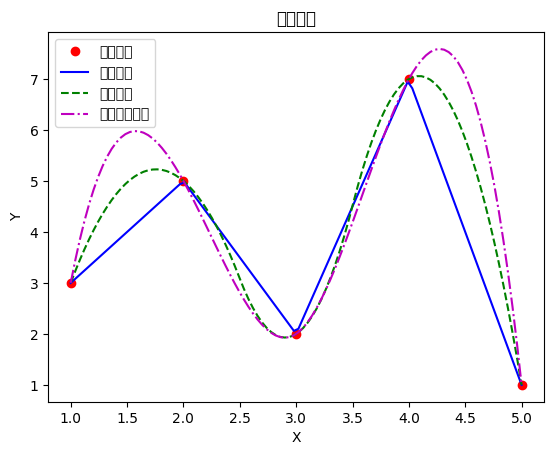

In [231]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# 原始数据点
x_known = np.array([1, 2, 3, 4, 5])
y_known = np.array([3, 5, 2, 7, 1])

# 生成更密集的 x 值用于插值
x_interp = np.linspace(x_known.min(), x_known.max(), 100)

# 使用线性插值
linear_interp = interp1d(x_known, y_known, kind='linear')
y_linear = linear_interp(x_interp)

# 使用二次插值（多项式插值）
quadratic_interp = interp1d(x_known, y_known, kind='quadratic')
y_quadratic = quadratic_interp(x_interp)

# 使用三次样条插值
cubic_interp = interp1d(x_known, y_known, kind='cubic')
y_cubic = cubic_interp(x_interp)

# 绘制原始数据和插值结果的曲线
plt.figure()
plt.plot(x_known, y_known, 'ro', label='原始数据')
plt.plot(x_interp, y_linear, 'b-', label='线性插值')
plt.plot(x_interp, y_quadratic, 'g--', label='二次插值')
plt.plot(x_interp, y_cubic, 'm-.', label='三次样条插值')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('曲线插值')
plt.legend()
plt.show()


最好沿着轨迹绘制图像
因为在轨迹上能够更好地展现速度的变化

In [232]:
import matplotlib.pyplot as plt
for i in range(len(track)):
    #print(track[i])
    v,Y,X=get_v_S_T(track[i])
    
    # 定义滑动窗口大小和滤波后的数据容器
    window_size = 3
    smoothed_data = np.zeros_like(v)

    # 应用移动平均滤波
    for i in range(window_size, len(v)-window_size):
        smoothed_data[i] = np.mean(v[i-window_size:i+window_size+1])
    # 绘制图像
    plt.plot(Y, smoothed_data, color='red', linewidth=2.0)
    plt.plot(Y, v, color='blue', linewidth=1.0,linestyle='--')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Sine Function')
    plt.grid(True)
    plt.show()
    

NameError: name 'get_v_S_T' is not defined

In [233]:
import matplotlib.pyplot as plt

colors=['red','blue','green','yellow','pink','purple','orange','gray','brown',
        'red','blue','green','yellow','pink','purple','orange','gray','brown',
        'red','blue','green','yellow','pink','purple','orange','gray','brown',]

t_a=0
for i in range(len(track)):
    #print(track[i])
    v,Y,X=get_v_S_T(track[i])
    
    # 定义滑动窗口大小和滤波后的数据容器
    window_size = 3
    smoothed_data = np.zeros_like(v)

    # 应用移动平均滤波
    
    for j in range(window_size, len(v)-window_size):
        smoothed_data[j] = np.mean(v[j-window_size:j+window_size+1])
    # 绘制图像
    plt.plot(X, Y, color=colors[i],  linewidth=2.0,linestyle='--')
    plt.axvline(x=X[-1], color=colors[i], linestyle='--')
    plt.xlabel('T')
    plt.ylabel('S')
    plt.title('Sine Function')
    plt.grid(True)
    t_a+=X[-1]
plt.axvline(x=(t_a)/len(track), color='black', linewidth=2.0)
plt.show()

NameError: name 'get_v_S_T' is not defined

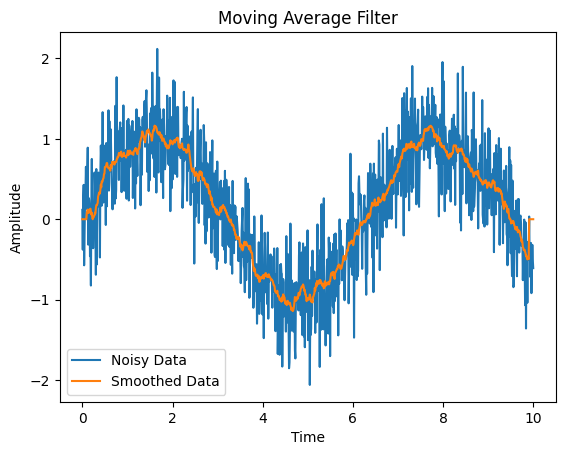

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 生成示例的含噪声的时序数据
t = np.linspace(0, 10, 1000)
y = np.sin(t) + 0.4 * np.random.randn(1000)

# 定义滑动窗口大小和滤波后的数据容器
window_size = 10
smoothed_data = np.zeros_like(y)

# 应用移动平均滤波
for i in range(window_size, len(y)-window_size):
    smoothed_data[i] = np.mean(y[i-window_size:i+window_size+1])

# 绘制原始数据和滤波后的数据
plt.plot(t, y, label='Noisy Data')
plt.plot(t, smoothed_data, label='Smoothed Data')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Moving Average Filter')
plt.legend()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

colors=['red','blue','green','yellow','pink','purple','orange','gray','brown',
        'red','blue','green','yellow','pink','purple','orange','gray','brown',]

def polynomial_func(x, *coefficients):
    n = int(len(coefficients)/2)
    result = np.zeros_like(x)
    for i in range(n):
        result += coefficients[i] * np.power(x,i)+coefficients[i+n]
    return result

Y=[]
X=[]
for i in range(len(track)):
    #print(track[i])
    _,s,t=get_v_S_T(track[i])
    Y.extend(s)
    X.extend(t)

# 使用 zip() 函数将两个列表配对并排序
sorted_pairs = sorted(zip(X, Y))

# 解压排序后的配对，重新组合成两个列表
X, Y = zip(*sorted_pairs)


# 使用最小二乘法进行拟合
initial_guess = np.zeros(8+8)  # 初始猜测参数
popt, pcov = curve_fit(polynomial_func, np.array(X), np.array(Y), p0=initial_guess)

#print(popt)
#print(pcov)
# 绘制原始数据和拟合曲线
plt.scatter(X, Y, color=colors[0],)
plt.plot(X, polynomial_func(X, *popt), color=colors[1], label='Fitted Curve')
plt.xlabel('T')
plt.ylabel('S')
plt.title('Curve Fitting Example')
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'get_v_S_T' is not defined

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

colors=['red','blue','green','yellow','pink','purple','orange','gray','brown',
        'red','blue','green','yellow','pink','purple','orange','gray','brown',]

def polynomial_func(x, *coefficients):
    n = int(len(coefficients)/2)
    result = np.zeros_like(x)
    for i in range(n):
        result += coefficients[i] * np.power(x,i)+coefficients[i+n]
    return result

Y=[]
X=[]
for i in range(len(track)):
    #print(track[i])
    _,s,t=get_v_S_T(track[i])
    Y.extend(s)
    X.extend(t)

# 使用 zip() 函数将两个列表配对并排序
sorted_pairs = sorted(zip(Y, X))

# 解压排序后的配对，重新组合成两个列表
Y,X = zip(*sorted_pairs)


# 使用最小二乘法进行拟合
initial_guess = np.zeros(8+8)  # 初始猜测参数
popt, pcov = curve_fit(polynomial_func, np.array(Y), np.array(X), p0=initial_guess)

#print(popt)
#print(pcov)
# 绘制原始数据和拟合曲线
plt.scatter(Y, X, color=colors[0],)
plt.plot(Y, polynomial_func(Y, *popt), color=colors[1], label='Fitted Curve')
plt.xlabel('S')
plt.ylabel('T')
plt.title('Curve Fitting Example')
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'get_v_S_T' is not defined

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

colors=['red','blue','green','yellow','pink','purple','orange','gray','brown',
        'red','blue','green','yellow','pink','purple','orange','gray','brown',]

def polynomial_func(x, *coefficients):
    n = int(len(coefficients)/2)
    result = np.zeros_like(x)
    for i in range(n):
        result += coefficients[i] * np.power(x,i)+coefficients[i+n]
    return result

for i in range(len(track)):
    #print(track[i])
    _,Y,X=get_v_S_T(track[i])


    '''    # 使用 zip() 函数将两个列表配对并排序
    sorted_pairs = sorted(zip(S, T))

    # 解压排序后的配对，重新组合成两个列表
    S,T = zip(*sorted_pairs)'''


    # 使用最小二乘法进行拟合
    initial_guess = np.zeros(8+8)  # 初始猜测参数
    popt, pcov = curve_fit(polynomial_func, np.array(Y), np.array(X), p0=initial_guess)

    #print(popt)
    #print(pcov)
    # 绘制原始数据和拟合曲线
    plt.scatter(Y, X, color=colors[0],)
    plt.plot(Y, polynomial_func(Y, *popt), color=colors[1], label='Fitted Curve')
    plt.xlabel('S')
    plt.ylabel('T')
    plt.title('Curve Fitting Example')
    plt.legend()
    plt.grid(True)
    plt.show()

NameError: name 'get_v_S_T' is not defined

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 示例轨迹数据
X = np.linspace(0, 2 * np.pi, 100)
y = np.sin(X)

# 计算曲率
dS = np.gradient(X)
dT = np.gradient(y)
d2S = np.gradient(dS)
d2T = np.gradient(dT)
curvature = np.abs(dS * d2T - dT * d2S) / np.power(dS**2 + dT**2, 1.5)

# 设置曲率阈值，判断转折点
threshold = 0.99
turning_points = np.where(curvature > threshold)[0]

# 绘制轨迹和转折点
plt.plot(X, y, label='Trajectory')
plt.scatter(X[turning_points], y[turning_points], color='red', label='Turning Points')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Trajectory with Turning Points')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

colors=['red','blue','green','yellow','pink','purple','orange','gray','brown',
        'red','blue','green','yellow','pink','purple','orange','gray','brown',]

def polynomial_func(x, *coefficients):
    n = int(len(coefficients)/2)
    result = np.zeros_like(x)
    for i in range(n):
        result += coefficients[i] * np.power(x,i)+coefficients[i+n]
    return result

for i in range(len(track)):
    #print(track[i])
    _,Y,X=get_v_S_T(track[i])


    # 使用 zip() 函数将两个列表配对并排序
    sorted_pairs = sorted(zip(Y, X))

    # 解压排序后的配对，重新组合成两个列表
    Y,X = zip(*sorted_pairs)

    # 计算曲率
    dS = np.gradient(Y)
    dT = np.gradient(X)
    d2S = np.gradient(dS)
    d2T = np.gradient(dT)
    curvature = np.abs(dS * d2T - dT * d2S) / np.power(dS**2 + dT**2, 1.5)

    # 设置曲率阈值，判断转折点
    threshold = 0.9
    turning_points = np.array(np.where(curvature > threshold)[0])
    
    # 使用最小二乘法进行拟合
    initial_guess = np.zeros(8+8)  # 初始猜测参数
    popt, pcov = curve_fit(polynomial_func, np.array(Y), np.array(X), p0=initial_guess)

    # 绘制原始数据和拟合曲线
    
    plt.scatter(Y, X, color=colors[0],)
    plt.plot(Y, polynomial_func(Y, *popt), color=colors[1], label='Fitted Curve')
    plt.scatter(np.array(Y)[turning_points], np.array(X)[turning_points], color='green', label='Turning Points')
    plt.xlabel('S')
    plt.ylabel('T')
    plt.title('Curve Fitting Example')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

colors=['red','blue','green','yellow','pink','purple','orange','gray','brown',
        'red','blue','green','yellow','pink','purple','orange','gray','brown',]

def polynomial_func(x, *coefficients):
    n = int(len(coefficients)/2)
    result = np.zeros_like(x)
    for i in range(n):
        result += coefficients[i] * np.power(x,i)+coefficients[i+n]
    return result

for i in range(len(track)):
    #print(track[i])
    _,Y,X=get_v_S_T(track[i])


    # 使用 zip() 函数将两个列表配对并排序
    sorted_pairs = sorted(zip(Y, X))

    # 解压排序后的配对，重新组合成两个列表
    X,Y = zip(*sorted_pairs)

    # 计算曲率
    dS = np.gradient(Y)
    dT = np.gradient(X)
    d2S = np.gradient(dS)
    d2T = np.gradient(dT)
    curvature = np.abs(dS * d2T - dT * d2S) / np.power(dS**2 + dT**2, 1.5)

    # 设置曲率阈值，判断转折点
    threshold = 0.1
    turning_points = np.array(np.where(curvature > threshold)[0])
    
    # 使用最小二乘法进行拟合
    initial_guess = np.zeros(8+8)  # 初始猜测参数
    popt, pcov = curve_fit(polynomial_func, np.array(Y), np.array(X), p0=initial_guess)

    # 绘制原始数据和拟合曲线
    
    plt.scatter(Y, X, color=colors[0],)
    plt.plot(Y, polynomial_func(Y, *popt), color=colors[1], label='Fitted Curve')
    plt.scatter(np.array(Y)[turning_points], np.array(X)[turning_points], color='green', label='Turning Points')
    plt.xlabel('S')
    plt.ylabel('T')
    plt.title('Curve Fitting Example')
    plt.legend()
    plt.grid(True)
    plt.show()